# Crowd Layer

In this brief tutorial, we show an example use-case of our package `skactiveml` with the Python package [skorch](https://skorch.readthedocs.io/en/stable/), which is a scikit-learn wrapper for Pytorch models. This way, we are able to implement and test deep learning models in combination with query strategies implemented in our framework.

In [1]:
import sys
sys.path.append('..')

import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from sklearn.metrics import accuracy_score
from torch import nn
import torch.nn.functional as F
from skorch.dataset import Dataset
from skorch.helper import predefined_split

mlp.rcParams["figure.facecolor"] = "white"

MISSING_LABEL = -1
RANDOM_STATE = 0
FONTSIZE = 12

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings("ignore")

## Loading Music Data Set

In [2]:
data_dir = "./music-multi-annotator-dataset"

In [3]:
X_train = np.load(f'{data_dir}/music-X.npy')
y_train = np.load(f'{data_dir}/music-y.npy')
y_train_true = np.load(f'{data_dir}/music-y-true.npy')
X_valid = np.load(f'{data_dir}/music-X-valid.npy')
y_valid = np.load(f'{data_dir}/music-y-true-valid.npy')
X_test = np.load(f'{data_dir}/music-X-test.npy')
y_test_true = np.load(f'{data_dir}/music-y-true-test.npy')

dataset_classes = np.unique(y_test_true)
n_classes = len(dataset_classes)
n_features = X_train.shape[1]

## Neural Network Ensemble for tabular data set
In the next step, we define a neural network ensemble for tabular data set

In [4]:
# Define base module.
class GroundTruthModule(nn.Module):
    def __init__(self, n_classes, dropout):
        super(GroundTruthModule, self).__init__()
        n_hidden_neurons = 128
        self.embed_X_block = nn.Sequential(
            nn.Linear(in_features=124, out_features=n_hidden_neurons),
            nn.BatchNorm1d(num_features=n_hidden_neurons),
            nn.ReLU(),
            nn.Dropout(p=dropout),
        )
        self.mlp = nn.Linear(in_features=n_hidden_neurons, out_features=n_classes)

    def forward(self, x):
        
        embed_x = self.embed_X_block(x)
        logit_class = self.mlp(embed_x)       

        # Compute class-membership probabilities.
        p_class = F.softmax(logit_class, dim=-1)

        return p_class

In [5]:
from classifier.crowd_layer_classifier import CrowdLayerClassifier
from classifier.skorch_classifier import SkorchClassifier
from skorch.callbacks import LRScheduler

In [6]:
# lr_scheduler = LRScheduler(policy="CosineAnnealingLR", T_max=50)
# crowd_layer_net = CrowdLayerClassifier(
#         module__n_annotators=y_train.shape[1],
#         module__gt_net=gt_net,
#         classes=dataset_classes,
#         missing_label=MISSING_LABEL,
#         cost_matrix=None,
#         random_state=1,
#         train_split=predefined_split(valid_ds),
#         verbose=False,
#         optimizer=torch.optim.AdamW,
#         device=device,
#         callbacks=[lr_scheduler],
#         **hyper_dict
#     )

In [7]:
valid_ds = Dataset(X_valid, y_valid)

In [8]:
hyper_dict = {
    'max_epochs': 200,
    'batch_size': 16,
    'optimizer_lr': 0.01,
    'optimizer__weight_decay': 0.0
}

In [9]:
gt_net = GroundTruthModule(n_classes=n_classes, dropout=0.0)
crowd_layer_net = CrowdLayerClassifier(
        module__n_annotators=y_train.shape[1],
        module__gt_net=gt_net,
        classes=dataset_classes,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=1,
        train_split=predefined_split(valid_ds),
        verbose=False,
        optimizer=torch.optim.AdamW,
        device=device,
        **hyper_dict
    )
crowd_layer_net.initialize()

<class 'classifier.crowd_layer_classifier.CrowdLayerClassifier'>[initialized](
  module_=CrowdLayerModule(
    (gt_net): GroundTruthModule(
      (embed_X_block): Sequential(
        (0): Linear(in_features=124, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.0, inplace=False)
      )
      (mlp): Linear(in_features=128, out_features=10, bias=True)
    )
    (annotator_layers): ModuleList(
      (0-43): 44 x Linear(in_features=10, out_features=10, bias=False)
    )
  ),
)

## Active Classification
For our ensemble, we evaluate four different query strategies, i.e., random sampling, uncertainty sampling, query-by-committee, and batch BALD, regarding their sample selection. For this purpose, we start with ten labels and make 30 iterations of an active learning cycle with a batch size of 32.

In [10]:
# Define setup.
torch.manual_seed(RANDOM_STATE)

crowd_layer_net.fit(X_train,y_train)

<class 'classifier.crowd_layer_classifier.CrowdLayerClassifier'>[initialized](
  module_=CrowdLayerModule(
    (gt_net): GroundTruthModule(
      (embed_X_block): Sequential(
        (0): Linear(in_features=124, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.0, inplace=False)
      )
      (mlp): Linear(in_features=128, out_features=10, bias=True)
    )
    (annotator_layers): ModuleList(
      (0-43): 44 x Linear(in_features=10, out_features=10, bias=False)
    )
  ),
)

In [11]:
y_train_pred = crowd_layer_net.predict(X_train)
train_accuracy = accuracy_score(y_train_true, y_train_pred)

y_pred = crowd_layer_net.predict(X_test)
test_accuracy = accuracy_score(y_pred, y_test_true)
# should be 0.785 from MaDL

print(train_accuracy, test_accuracy)

0.4042857142857143 0.42


In [12]:
history = crowd_layer_net.history

<class 'list'>


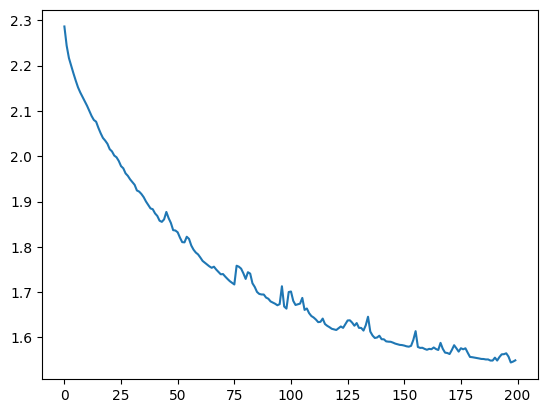

In [13]:
train_loss = history[:, 'train_loss']
plt.plot(train_loss)
print(train_loss.__class__)